<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-22 20:12:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2022-03-22 20:12:59 (15.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



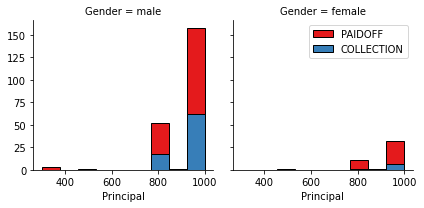

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

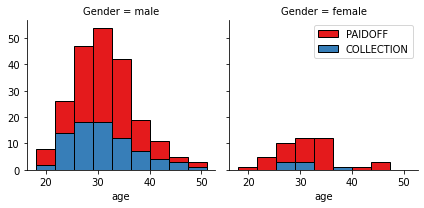

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


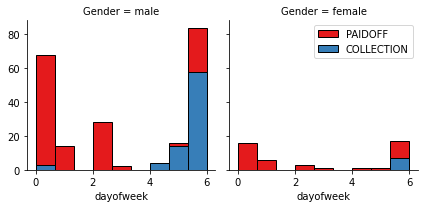

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [21]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [22]:
# calculate the accuracy of KNN for different values of k
ks=15
mean_acc = np.zeros((ks-1))
std_acc = np.zeros((ks-1))

for n in range(1,ks):
    
    #train de model and predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat)
    
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.70114943, 0.62068966, 0.75862069, 0.75862069, 0.7816092 ,
       0.77011494, 0.79310345, 0.77011494, 0.77011494, 0.73563218,
       0.73563218, 0.71264368, 0.70114943, 0.75862069])

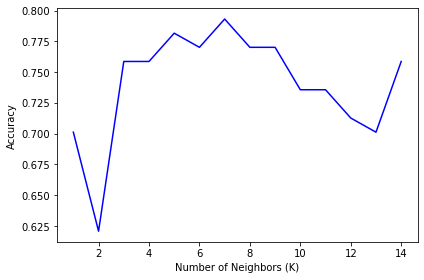

In [23]:
#plotting the model accuracy for a different number of neighbors
plt.plot(range(1,ks),mean_acc,'b')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()


In [24]:
#return the best k
print('The best accuracy was ', mean_acc.max(), 'with K = ', mean_acc.argmax()+1)

The best accuracy was  0.7931034482758621 with K =  7


In [25]:
k = 7
#Train Model 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

#Predict
yhat = neigh.predict(X_test)
print(yhat[0:5])

#Accuracy evaluation
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Train set Accuracy:  0.803088803088803
Test set Accuracy:  0.7931034482758621


In [26]:
#f1_score
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.7774100565816163

In [27]:
#jaccard index
from sklearn.metrics import jaccard_score
jaccard_score(y_test,yhat,pos_label='PAIDOFF')

0.7662337662337663

# Decision Tree


In [28]:
# import libraries
from sklearn.tree import DecisionTreeClassifier

In [29]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [30]:
#modeling
loan_tree = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
loan_tree.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [31]:
predTree = loan_tree.predict(X_test)

In [32]:
#prediction
print(predTree[0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [33]:
print("DecisionTrees' Accuracy: ",metrics.accuracy_score(y_test,loan_tree.predict(X_test)))

DecisionTrees' Accuracy:  0.735632183908046


In [34]:
#f1_score
f1_score(y_test, predTree, average='weighted')

0.6235822486107939

In [35]:
#jaccard index
jaccard_score(y_test,predTree,pos_label='PAIDOFF')

0.735632183908046

# Support Vector Machine


In [36]:
#changing to int values
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [37]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [38]:
df['loan_status'] = df['loan_status'].astype('int')
y = np.asarray(df['loan_status'])
y[0:5]

array([0, 0, 0, 0, 0])

In [39]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [40]:
#using default RBF (Radial Basis Function)
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [41]:
yhat = clf.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0])

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [43]:
def plot_confusion_matrix(cm,classes,normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j],fmt), horizontalalignment='center', color='white' if cm[i,j]> thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        64
           1       1.00      0.04      0.08        23

    accuracy                           0.75        87
   macro avg       0.87      0.52      0.47        87
weighted avg       0.81      0.75      0.65        87

Confusion matrix, without normalization
[[64  0]
 [22  1]]


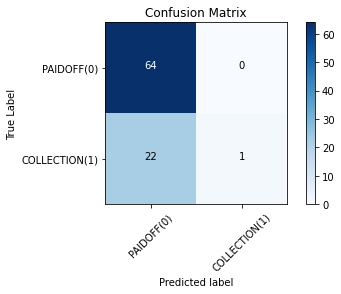

In [44]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_test,yhat))

#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)', 'COLLECTION(1)'], normalize = False, title='Confusion Matrix')

In [45]:
print("SVM' Accuracy: ",metrics.accuracy_score(y_test,yhat))

SVM' Accuracy:  0.7471264367816092


In [46]:
#f1_score
f1_score(y_test, yhat, average='weighted')

0.6497701149425287

In [47]:
#jaccard index
jaccard_score(y_test,yhat,pos_label=0)

0.7441860465116279

# Logistic Regression


In [48]:
# Define X and Y
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)
y = df['loan_status'].values

print(X[0:5])
print(y[0:5])

[[ 0.52  0.92  2.33 -0.42 -1.21 -0.38  1.14 -0.87]
 [ 0.52  0.92  0.34  2.38 -1.21  2.62 -0.88 -0.87]
 [ 0.52 -0.96 -0.65 -0.42 -1.21 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.49  2.38  0.83 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.32 -0.42  0.83 -0.38 -0.88  1.15]]
[0 0 0 0 0]


In [49]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [50]:
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [51]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
#predict probability
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:50]

array([[0.51, 0.49],
       [0.55, 0.45],
       [0.69, 0.31],
       [0.65, 0.35],
       [0.67, 0.33],
       [0.68, 0.32],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.65, 0.35],
       [0.52, 0.48],
       [0.66, 0.34],
       [0.51, 0.49],
       [0.74, 0.26],
       [0.66, 0.34],
       [0.57, 0.43],
       [0.73, 0.27],
       [0.49, 0.51],
       [0.69, 0.31],
       [0.51, 0.49],
       [0.68, 0.32],
       [0.55, 0.45],
       [0.51, 0.49],
       [0.5 , 0.5 ],
       [0.53, 0.47],
       [0.58, 0.42],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.62, 0.38],
       [0.5 , 0.5 ],
       [0.73, 0.27],
       [0.54, 0.46],
       [0.54, 0.46],
       [0.55, 0.45],
       [0.52, 0.48],
       [0.61, 0.39],
       [0.54, 0.46],
       [0.51, 0.49],
       [0.7 , 0.3 ],
       [0.55, 0.45],
       [0.55, 0.45],
       [0.5 , 0.5 ],
       [0.67, 0.33],
       [0.55, 0.45],
       [0.51, 0.49],
       [0.68, 0.32],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.51,

Confusion matrix, without normalization
[[ 0 23]
 [ 2 62]]


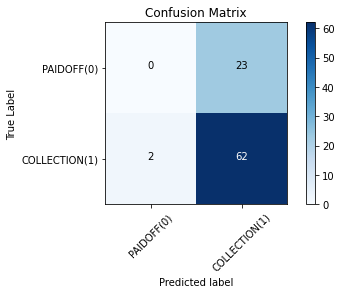

In [53]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test,yhat,labels=[1,0])
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=['PAIDOFF(0)', 'COLLECTION(1)'], normalize = False, title='Confusion Matrix')

In [54]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83        64
           1       0.00      0.00      0.00        23

    accuracy                           0.71        87
   macro avg       0.36      0.48      0.42        87
weighted avg       0.54      0.71      0.61        87



In [55]:
#f1_score
f1_score(y_test, yhat, average='weighted')

0.6122039651315281

In [56]:
#jaccard index
jaccard_score(y_test,yhat,pos_label=0)

0.7126436781609196

In [57]:
# log loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5762724065080442

# Model Evaluation using Test set


In [58]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [59]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-22 20:13:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-22 20:13:19 (96.4 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [60]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [61]:
test_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [62]:
Feature_real = df[['Principal','terms','age','Gender','weekend']]
Feature_real = pd.concat([Feature_real,pd.get_dummies(df['education'])], axis=1)
Feature_real.drop(['Master or Above'], axis = 1,inplace=True)
Feature_real.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [63]:
X_real = Feature_real
X_real[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [64]:
y_real = test_df['loan_status'].values
y_real[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [65]:
#changing PAIDOFF and COLLECTION into int values
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)


test_df['loan_status'] = df['loan_status'].astype('int')
y_real = np.asarray(df['loan_status'])

print(y_real[0:5])

[0 0 0 0 0]


In [66]:
X_real = preprocessing.StandardScaler().fit(X_real).transform(X_real)
X_real[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [67]:
# KNN 

k = 7
#Train Model 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_real,y_real)

#Predict
yhat = neigh.predict(X_real)
print(yhat[0:5])

[0 0 0 0 0]


In [68]:
# KNN f1_score
KNN_f1_score = f1_score(y_real, yhat, average='weighted')

# KNN jaccard index
KNN_jaccard_index = jaccard_score(y_real,yhat,pos_label=0)


print('KNN f1_score =',KNN_f1_score)
print("KNN jaccard index =",KNN_jaccard_index)

KNN f1_score = 0.7828558464207114
KNN jaccard index = 0.7781350482315113


In [69]:
# DECISION TREE

#modeling
loan_tree = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
loan_tree.fit(X_real,y_real)

#prediction
y_tree_pred = loan_tree.predict(X_real)

print(y_tree_pred[0:5])
print(y_real[0:5])

[0 0 0 0 0]
[0 0 0 0 0]


In [70]:
# DECISION TREE f1_score
dectree_f1_score = f1_score(y_real, y_tree_pred, average='weighted')

# DECISION TREE jaccard index
dectree_jaccard_index = jaccard_score(y_real,y_tree_pred,pos_label=0)


print("Decision Tree f1_score =", dectree_f1_score)
print("Decision Tree jaccard index =",dectree_jaccard_index)

Decision Tree f1_score = 0.6448043648295465
Decision Tree jaccard index = 0.7514450867052023


[0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       260
           1       1.00      0.02      0.05        86

    accuracy                           0.76       346
   macro avg       0.88      0.51      0.45       346
weighted avg       0.82      0.76      0.66       346

Confusion matrix, without normalization
[[260   0]
 [ 84   2]]


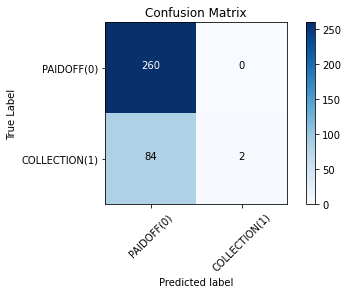

In [71]:
# SVM

yhat_SVM = clf.predict(X_real)
print(yhat_SVM[0:5])

#compute confusion matrix
cnf_matrix = confusion_matrix(y_real, yhat_SVM, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_real,yhat_SVM))

#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)', 'COLLECTION(1)'], normalize = False, title='Confusion Matrix')

In [72]:
# SVM f1_score
SVM_f1_score = f1_score(y_real, yhat_SVM, average='weighted')

# SVM jaccard index
SVM_jaccard_index = jaccard_score(y_real,yhat_SVM,pos_label=0)


print("SVM f1_score =", SVM_f1_score)
print("SVM jaccard index =",SVM_jaccard_index)

SVM f1_score = 0.6582374292246818
SVM jaccard index = 0.7558139534883721


In [73]:
# LOGISTIC REGRESSION
# Modeling
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)

yhat_LR = LR.predict(X_real)
print(yhat_LR)

#predict probability
yhat_prob_LR = LR.predict_proba(X_real)
yhat_prob_LR[0:50]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([[0.69, 0.31],
       [0.74, 0.26],
       [0.72, 0.28],
       [0.58, 0.42],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.57, 0.43],
       [0.62, 0.38],
       [0.55, 0.45],
       [0.52, 0.48],
       [0.63, 0.37],
       [0.55, 0.45],
       [0.57, 0.43],
       [0.52, 0.48],
       [0.54, 0.46],
       [0.51, 0.49],
       [0.54, 0.46],
       [0.52, 0.48],
       [0.5 , 0.5 ],
       [0.55, 0.45],
       [0.51, 0.49],
       [0.57, 0.43],
       [0.55, 0.45],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.56, 0.44],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.57, 0.43],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.61, 0.39],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.59, 0.41],
       [0.57, 0.43],
       [0.5 , 0.5 ],
       [0.53, 0.47],
       [0.57, 0.43],
       [0.57, 0.43],
       [0.62, 0.38],
       [0.51, 0.49],
       [0.5 , 0.5 ],
       [0.55, 0.45],
       [0.51,

In [74]:
# LR f1_score
LR_f1_score = f1_score(y_real, yhat_LR, average='weighted')

# LR jaccard index
LR_jaccard_index = jaccard_score(y_real,yhat_LR,pos_label=0)

# LR log loss
LR_log_loss = log_loss(y_real, yhat_prob_LR)

print("Logistic Regression f1_score =", LR_f1_score)
print("Logistic Regression jaccard index =",LR_jaccard_index)
print("Logistic Regression log loss =",LR_log_loss)

Logistic Regression f1_score = 0.6433860411789996
Logistic Regression jaccard index = 0.7485549132947977
Logistic Regression log loss = 0.5430553956239154


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.783   | 0.778        | NA      |
| Decision Tree      | 0.645   | 0.751        | NA      |
| SVM                | 0.658   | 0.756        | NA      |
| LogisticRegression | 0.643   | 0.748        | 0.543   |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
